# Global Black Box Optimization with RNNS
Project by Pattarawat Chormai and Felix Sattler ||
Supervised by Raphael Holca-Lamarre

In [37]:
# Imports
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import gpfunctions as gp
import lstm_model
import data
import sk_optimization
import imp
imp.reload(gp)

<module 'gpfunctions' from '/Users/heytitle/projects/neural-network-project/gpfunctions.py'>

## Set all the Hyperparameters

In [41]:
# Data
load_data = False
save_data = False
dim = 2
n_train = 1000
n_test = 100
n_bumps = 6
l = 2/n_bumps*np.sqrt(dim)
n_mc_samples = 1000
max_x_abs_value = 1.0
kernel = gp.rbf_kernel
function = gp.benchmark_prior3

# LSTM Model
n_hidden = 100
n_steps = 20

# Optimization
x_start = np.zeros(dim).reshape(1,dim)
epochs = 100
gradient_clipping = 1.0
forget_bias = 5.0
rate_init = 0.01
rate_final = 0.0001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 1
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "OI", "SUMIN", "WSUM_EXPO", "SUMOI", 'DIST'][3]

# Visualization
visualize = True

## Create Training Data or load from Disk

In [42]:
# Create Data or Load Data from Disk
if load_data:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = data.load_data
else:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    data.gen_data(n_train, n_test, dim, n_bumps, l, kernel, n_mc_samples)
# Save Data to Disk
if save_data:
    save_data(n_train, n_test, dim, n_bumps, l, n_mc_samples = 100)
        
data_train = (X_train, A_train, min_train, max_train)
data_test = (X_test, A_test, min_test, max_test)

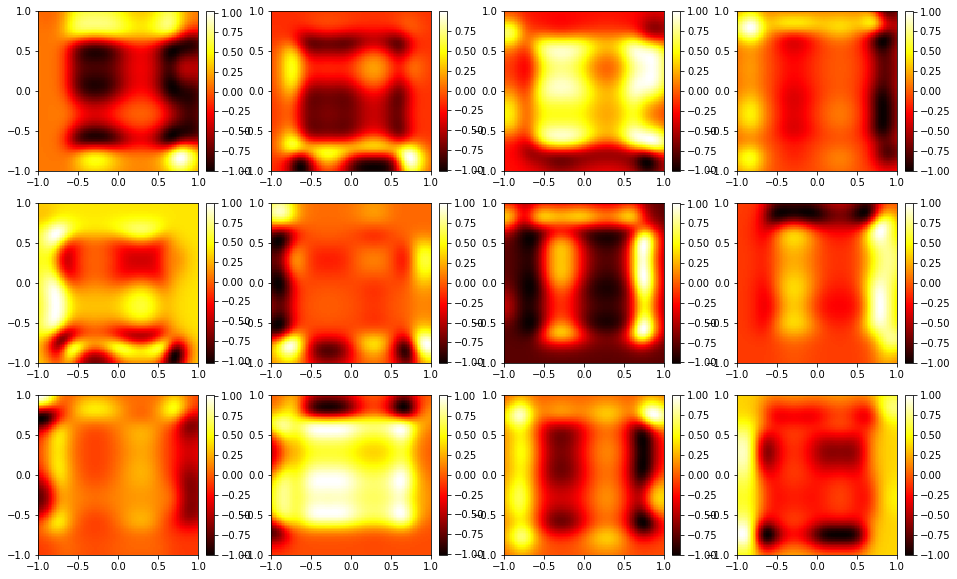

In [43]:
# Visualize Training Data
if visualize: viz.plot_gp_data_sample(12, X_train, A_train, min_train, max_train, l, kernel, function)

## Compute random Baseline

In [ ]:
samples_random_x, samples_random_y = sk_optimization.SKOptimizer().get_samples_sk(X_test, A_test, min_test, max_test, l, dim, \
                                                            n_steps+1, function, kernel, n_test, x_start.flatten(), "random")

In [ ]:
viz.plot_gp_results_sample(10, X_test[:10], A_test[:10], min_test[:10], \
                           max_test[:10], l, samples_random_x, samples_random_y, kernel, function)

## Compute SkOpt Baseline

In [ ]:
samples_sk_x, samples_sk_y = sk_optimization.SKOptimizer().get_samples_sk(X_test, A_test, min_test, max_test, l, dim, \
                                                            n_steps+1, function, kernel, 10, x_start.flatten(), "forest")

In [ ]:
viz.plot_gp_results_sample(10, X_test[:10], A_test[:10], min_test[:10], \
                           max_test[:10], l, samples_sk_x, samples_sk_y, kernel, function)

## Start a Session and train the model

In [ ]:
# Build the training graph, collect placeholders, sample sequence and lstmcell parameters 
Xt, At, mint, maxt, samples_x, samples_y, x_0, cell, weights = \
    lstm_model.build_training_graph(n_bumps, dim, n_hidden, forget_bias, n_steps, l, kernel, function)
placeholders = {"Xt": Xt, "At": At, "mint": mint, "maxt": maxt, "x0": x_0}

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
train_logs = lstm_model.train_model(sess, placeholders, samples_x, samples_y, epochs, batch_size, data_train, data_test,
                     rate_init, rate_decay, gradient_clipping, loss_type, x_start, max_x_abs_value, log = True)

In [ ]:
viz.visualize_learning(train_logs)

## Evaluate the Model on Training Data

In [ ]:
# Show results on Training Data
samples_train_x, samples_train_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_train, x_start)
    
viz.plot_gp_results_sample(10, X_train, A_train, min_train, max_train, l, samples_train_x, samples_train_y, kernel, function)

In [ ]:
viz.plot_min_curves([np.array(samples_random_y_train), samples_train_y, np.array(samples_sk_y_train)],['Random','OI','SkOpt'])

## Evaluate the Model on Test Data

In [ ]:
# Show results on Test Data
samples_test_x, samples_test_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_test, x_start)

viz.plot_gp_results_sample(10, X_test, A_test, min_test, max_test, l, samples_test_x, samples_test_y, kernel, function)

In [ ]:
viz.plot_min_curves([np.array(samples_random_y), samples_test_y, np.array(samples_sk_y)],['Random','OI','SkOpt'])

## Evaluate the Model on Benchmark Functions

In [ ]:
f_bm = [bf.branin, bf.goldstein_price, bf.hartmann3, bf.hartmann6][1]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf, bf.hartmann3_tf, bf.hartmann6_tf][1]

In [ ]:
samples_benchmark_x, samples_benchmark_y = \
        lstm_model.get_benchmark_samples(sess, f_bm_tf, cell, weights, dim, n_hidden, n_steps, x_start)

In [ ]:
viz.plot_result(f_bm, dim, 1, samples_benchmark_x, samples_benchmark_y)

## Generate Sequence of sample points sequentially

In [ ]:
def get_y(x):
    # Can be any arbitrary function that gets a (1,dim) numpy array as input and returns a (1,1) numpy array
    return np.sum(x**2).reshape(1,1)-1

def generate_sample_sequence(x0, steps):
    h_0 = tf.zeros([1, n_hidden])
    c_0 = tf.zeros([1, n_hidden])

    x = tf.constant(x0, dtype=tf.float32)
    state = (c_0, h_0)

    y0 = get_y(x0)
    y = tf.constant(y0, dtype=tf.float32)
    
    samples_x = [x0]
    samples_y = [y0]
    
    for i in range(steps):
        x, state = lstm_model.next_sample_point(x,y,state,cell,weights, scope="rnn_cell")
        x_np = sess.run(x)
        y_np = get_y(x_np)
        y = tf.constant(y_np, dtype=tf.float32)
        
        samples_x += [x_np]
        samples_y += [y_np]
        
    return samples_x, samples_y

In [ ]:
samples_x, samples_y = generate_sample_sequence(np.ones([1,dim]), steps = 20)

In [ ]:
samples_y